In [1]:
# Magnetic moment classifier using SVM
# https://arxiv.org/abs/1806.07989

# Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import itertools
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions

from tqdm.notebook import tqdm

# Load Datasets

In [4]:
print(os.listdir('../datasets'))

['.DS_Store', 'datatrain.csv', 'datatest.csv']


In [5]:
df_train = pd.read_csv('../datasets/datatrain.csv')
df_test = pd.read_csv('../datasets/datatest.csv')

X_train = df_train.drop(['structure', 'class'], axis=1)
y_train = df_train['class'].values

X_test = df_test.drop(['structure', 'class'], axis=1)
y_test = df_test['class'].values

In [6]:
X_train.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,m6,m7,m8,m9,m10,mtot,fermi,band,toten,nelectrons
0,3.11426,1.79802,11.54446,6.22852,3.59604,11.54424,-0.0,-0.0,10.34873,-0.0,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-3.158349,-483.374457,-40.380609,62.0
1,3.38614,1.95499,11.00558,6.77228,3.90998,11.00853,0.0,-0.0,9.86708,0.0,...,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-1.873443,-379.251497,-35.261134,62.0
2,3.11492,1.79840,10.62429,6.22985,3.59680,10.62447,-0.0,0.0,9.51753,-0.0,...,0.044,0.061,0.015,0.010,0.013,0.547,-2.335318,-482.074122,-41.354746,63.0
3,3.39551,1.96040,10.40155,6.79103,3.92081,10.40574,-0.0,-0.0,9.32076,-0.0,...,0.034,0.040,0.005,0.011,0.004,0.524,-1.352459,-389.016012,-36.503814,63.0
4,3.08785,1.78277,10.83735,6.17572,3.56555,10.83811,-0.0,-0.0,9.72958,0.0,...,0.000,0.000,0.000,0.000,0.000,-0.000,-3.043384,-472.035630,-41.755620,62.0


# Helpers

In [7]:
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [8]:
kernel = ['poly']

param_grid = {
    'kernel': kernel,
    'C': [0.1, 0.5, 1, 10, 30, 40, 50, 70, 100, 500, 1000],
    'gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipe = [('pca', PCA()), ('classifier', SVC())]
param_grid_pca = {
    'pca__n_components': [2],
    'classifier__kernel': kernel,
    'classifier__C': [0.1, 0.5, 1, 10, 30, 40, 50, 70, 100, 500, 1000],
    'classifier__gamma': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe)

# Scenario 1: Full Feature

In [9]:
grid1 = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, refit=True)
grid1.fit(X_train, y_train)

print('Best score: {}'.format(grid1.score(X_test, y_test)))
print('Best params: {}'.format(grid1.best_params_))

Best score: 0.9666666666666667
Best params: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}


In [10]:
y_pred1 = grid1.predict(X_test)
print('SVM accuracy with best params: {}'.format(accuracy_score(y_pred1, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}'.format(y_pred1))

SVM accuracy with best params: 0.9666666666666667
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]


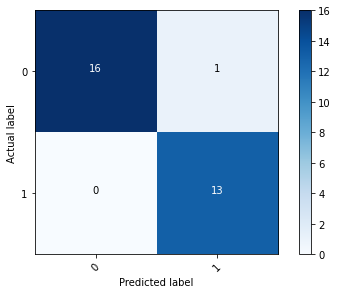

In [11]:
cm1 = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cm1, [0, 1])

In [12]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.93      1.00      0.96        13

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



# Scenario 2: Selected Feature

In [13]:
X_train2 = df_train[['m1', 'm2', 'mtot', 'nelectrons', 'fermi']]
X_test2 = df_test[['m1', 'm2', 'mtot', 'nelectrons', 'fermi']]

In [14]:
X_train2.head()

,m1,m2,mtot,nelectrons,fermi
0,0.000,0.000,0.000,62.0,-3.158349
1,0.000,0.000,0.000,62.0,-1.873443
2,0.142,0.142,0.547,63.0,-2.335318
3,0.177,0.177,0.524,63.0,-1.352459
4,-0.000,-0.000,-0.000,62.0,-3.043384


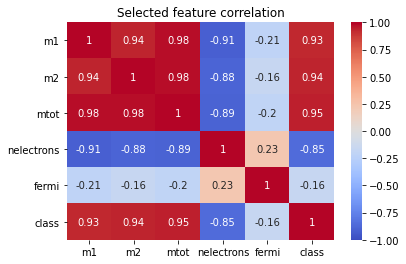

In [15]:
plt.title('Selected feature correlation')
corr_df = pd.concat([X_train2, df_train['class']], axis=1)
sns.heatmap(corr_df.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='coolwarm')

In [16]:
grid2 = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, refit=True)
grid2.fit(X_train2, y_train)

print('Best score: {}'.format(grid2.score(X_test2, y_test)))
print('Best params: {}'.format(grid2.best_params_))

Best score: 0.9666666666666667
Best params: {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}


In [17]:
y_pred2 = grid2.predict(X_test2)
print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred2, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}'.format(y_pred2))

SVM Accuracy with best params: 0.9666666666666667
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0]


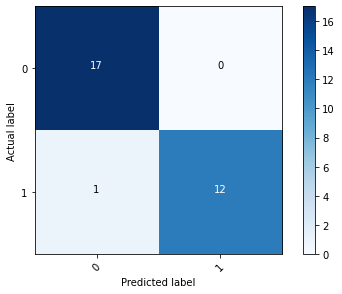

In [18]:
cm2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(cm2, [0, 1])

In [19]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



# PCA

In [20]:
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)

# PCA with all features
X_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca = pd.DataFrame(data=X_transformed, columns=columns)
df_pca = pd.concat([df_pca['Principal Component 1'], df_pca['Principal Component 2'], df_train['class']], axis = 1)

# PCA with selected features
X_transformed2 = pca2.fit_transform(X_train2)
X_test_transformed2 = pca2.transform(X_test2)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca2 = pd.DataFrame(data=X_transformed2, columns=columns)
df_pca2 = pd.concat([df_pca2['Principal Component 1'], df_pca2['Principal Component 2'], df_train['class']], axis=1)

In [21]:
print('PCA with all features variance ratio:      {}'.format(pca.explained_variance_ratio_))
print('PCA with selected features variance ratio: {}'.format(pca2.explained_variance_ratio_))

PCA with all features variance ratio:      [0.98037158 0.0137362 ]
PCA with selected features variance ratio: [0.92778479 0.04857948]


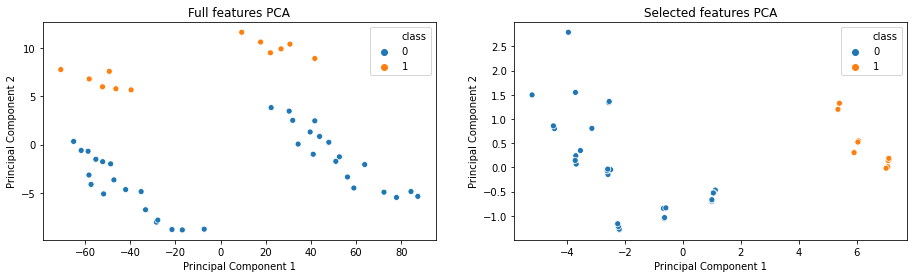

In [22]:
fig, ax =plt.subplots(1,2)
ax[0].set_title('Full features PCA')
ax[1].set_title('Selected features PCA')
sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[0])
sns.scatterplot(data=df_pca2, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[1])
plt.subplots_adjust(left=2, right=4)
fig.show()

# Scenario 3: Full Feature & PCA

In [23]:
grid3 = GridSearchCV(pipeline, param_grid=param_grid_pca, cv=5)
grid3.fit(X_transformed, y_train)

print('Best score: {}'.format(grid3.score(X_test_transformed, y_test)))
print('Best params: {}'.format(grid3.best_params_))

Best score: 0.6333333333333333
Best params: {'classifier__C': 0.1, 'classifier__gamma': 0.005, 'classifier__kernel': 'poly', 'pca__n_components': 2}


In [24]:
y_pred3 = grid3.predict(X_test_transformed)
print('SVM accuracy with best params: {}'.format(accuracy_score(y_pred3, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}'.format(y_pred3))

SVM accuracy with best params: 0.6333333333333333
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]


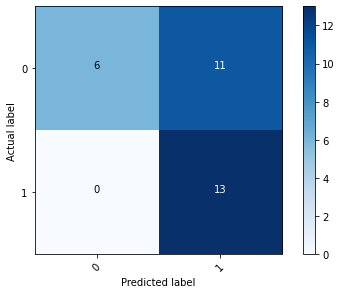

In [25]:
cm3 = confusion_matrix(y_test, y_pred3)
plot_confusion_matrix(cm3, [0, 1])

In [26]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       1.00      0.35      0.52        17
           1       0.54      1.00      0.70        13

    accuracy                           0.63        30
   macro avg       0.77      0.68      0.61        30
weighted avg       0.80      0.63      0.60        30



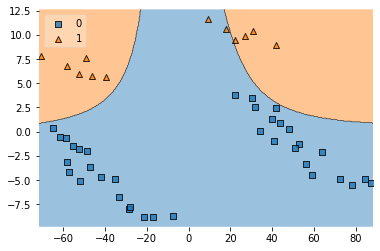

In [27]:
plot_decision_regions(X_transformed, y_train, clf=grid3, legend=2)

# Scenario 4: Selected Feature & PCA

In [28]:
grid4 = GridSearchCV(pipeline, param_grid=param_grid_pca, cv=5)
grid4.fit(X_transformed2, y_train)

print('Best score: {}'.format(grid4.score(X_test_transformed2, y_test)))
print('Best params: {}'.format(grid4.best_params_))

Best score: 0.9333333333333333
Best params: {'classifier__C': 0.1, 'classifier__gamma': 0.05, 'classifier__kernel': 'poly', 'pca__n_components': 2}


In [29]:
y_pred4 = grid4.predict(X_test_transformed2)
print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred4, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}'.format(y_pred4))

SVM Accuracy with best params: 0.9333333333333333
Actual test label:    [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0]
Predicted test label: [0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0]


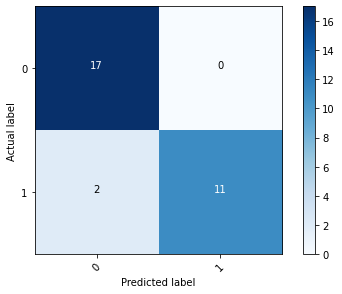

In [30]:
cm4 = confusion_matrix(y_test, y_pred4)
plot_confusion_matrix(cm4, [0, 1])

In [31]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       1.00      0.85      0.92        13

    accuracy                           0.93        30
   macro avg       0.95      0.92      0.93        30
weighted avg       0.94      0.93      0.93        30



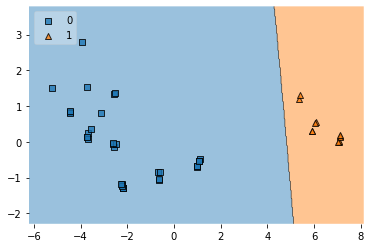

In [32]:
plot_decision_regions(X_transformed2, y_train, clf=grid4, legend=2)